# 🧠 U-Net Autoencoder Training on 48³ Patches with SSIM Loss

In [1]:

import os
import numpy as np
import SimpleITK as sitk
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from piqa import SSIM
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


In [2]:

class SmallPatchNiftiDataset(Dataset):
    def __init__(self, file_list, target_size=(48, 48, 48)):
        self.file_list = file_list
        self.target_size = target_size  # (D, H, W)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img).astype(np.float32)  # [D_orig, H_orig, W_orig]
        D, H, W = arr.shape
        d, h, w = self.target_size

        # Center-crop if larger
        if (D >= d) and (H >= h) and (W >= w):
            sd = (D - d) // 2
            sh = (H - h) // 2
            sw = (W - w) // 2
            patch = arr[sd:sd+d, sh:sh+h, sw:sw+w]
        else:
            # Resample to target_size
            orig_sp = img.GetSpacing()  # (x, y, z) spacing
            orig_sz = img.GetSize()     # (W_orig, H_orig, D_orig)
            new_sp = (
                orig_sp[2] * (orig_sz[2] / d),
                orig_sp[1] * (orig_sz[1] / h),
                orig_sp[0] * (orig_sz[0] / w)
            )
            resampler = sitk.ResampleImageFilter()
            resampler.SetOutputSpacing((new_sp[2], new_sp[1], new_sp[0]))
            resampler.SetSize((w, h, d))
            resampler.SetOutputOrigin(img.GetOrigin())
            resampler.SetOutputDirection(img.GetDirection())
            resampler.SetInterpolator(sitk.sitkLinear)
            img_res = resampler.Execute(img)
            patch = sitk.GetArrayFromImage(img_res).astype(np.float32)

        # Z-score and min-max normalize to [0,1]
        mean, std = np.mean(patch), np.std(patch)
        z = (patch - mean) / (std + 1e-5)
        zmin, zmax = z.min(), z.max()
        z = (z - zmin) / (zmax - zmin)
        z = np.clip(z, 0.0, 1.0)

        # Return tensor [1, d, h, w]
        return torch.tensor(z[np.newaxis, ...], dtype=torch.float32)


In [3]:

class UNetAutoencoder3D(nn.Module):
    def __init__(self):
        super(UNetAutoencoder3D, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(1, 32, 3, padding=1), 
            nn.BatchNorm3d(32), 
            nn.ReLU()
        )  # -> [32,48,48,48]
        self.pool1 = nn.MaxPool3d(2)  # -> [32,24,24,24]

        self.enc2 = nn.Sequential(
            nn.Conv3d(32, 64, 3, padding=1), 
            nn.BatchNorm3d(64), 
            nn.ReLU()
        )  # -> [64,24,24,24]
        self.pool2 = nn.MaxPool3d(2)  # -> [64,12,12,12]

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv3d(64, 128, 3, padding=1), 
            nn.ReLU(),
            nn.Conv3d(128, 64, 3, padding=1), 
            nn.ReLU()
        )  # -> [64,12,12,12]

        # Decoder
        self.up2 = nn.ConvTranspose3d(64, 64, 2, stride=2)  # -> [64,24,24,24]
        self.dec2 = nn.Sequential(
            nn.Conv3d(128, 64, 3, padding=1), 
            nn.BatchNorm3d(64), 
            nn.ReLU()
        )  # -> [64,24,24,24]

        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)  # -> [32,48,48,48]
        self.dec1 = nn.Sequential(
            nn.Conv3d(64, 32, 3, padding=1), 
            nn.BatchNorm3d(32), 
            nn.ReLU()
        )  # -> [32,48,48,48]

        self.final = nn.Conv3d(32, 1, 1)  # -> [1,48,48,48]

    def forward(self, x):
        x1 = self.enc1(x)          # [B,32,48,48,48]
        p1 = self.pool1(x1)        # [B,32,24,24,24]
        x2 = self.enc2(p1)         # [B,64,24,24,24]
        p2 = self.pool2(x2)        # [B,64,12,12,12]
        b  = self.bottleneck(p2)   # [B,64,12,12,12]

        u2 = self.up2(b)           # [B,64,24,24,24]
        c2 = torch.cat([u2, x2], dim=1)  # [B,128,24,24,24]
        d2 = self.dec2(c2)         # [B,64,24,24,24]

        u1 = self.up1(d2)          # [B,32,48,48,48]
        c1 = torch.cat([u1, x1], dim=1)  # [B,64,48,48,48]
        d1 = self.dec1(c1)         # [B,32,48,48,48]

        out = self.final(d1)       # [B,1,48,48,48]
        return out


In [5]:

# Load file paths and split
t1_files = sorted(glob(r'D:\DS18\data\IXI-T1_resampled\*.nii.gz'))
#t2_files = sorted(glob("/mnt/data/IXI-T2_resampled/*.nii.gz"))
all_files = t1_files #+ t2_files
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Create datasets and loaders
train_ds = SmallPatchNiftiDataset(train_files, target_size=(48,48,48))
val_ds   = SmallPatchNiftiDataset(val_files,   target_size=(48,48,48))
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=1)


In [6]:

# Model, optimizer, losses, TensorBoard
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetAutoencoder3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()
ssim_loss = SSIM(n_channels=1).to(device)
writer = SummaryWriter(log_dir="runs/unet_patch_training")


In [9]:

# Training loop with validation & early stopping
best_val_loss = float("inf")
patience, patience_counter = 5, 0
n_epochs = 50
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)  # [1,1,48,48,48]
        optimizer.zero_grad()
        output = model(batch)

        # Clamp before SSIM
        output_clamped = torch.clamp(output, 0.0, 1.0)

        # Combined MSE + SSIM loss
        loss = 0.8 * mse_loss(output, batch) + 0.2 * (1 - ssim_loss(output_clamped, batch))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)

            output_clamped = torch.clamp(output, 0.0, 1.0)
            loss = 0.8 * mse_loss(output, batch) + 0.2 * (1 - ssim_loss(output_clamped, batch))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    writer.add_scalars("Loss", {"Train": train_loss, "Val": val_loss}, epoch + 1)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_autoencoder_patch.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

writer.close()

Epoch 1, Train Loss: 0.0417, Val Loss: 0.0123
Epoch 2, Train Loss: 0.0194, Val Loss: 0.0167
Epoch 3, Train Loss: 0.0154, Val Loss: 0.0100
Epoch 4, Train Loss: 0.0116, Val Loss: 0.0083
Epoch 5, Train Loss: 0.0098, Val Loss: 0.0047
Epoch 6, Train Loss: 0.0082, Val Loss: 0.0111
Epoch 7, Train Loss: 0.0072, Val Loss: 0.0088
Epoch 8, Train Loss: 0.0066, Val Loss: 0.0037
Epoch 9, Train Loss: 0.0062, Val Loss: 0.0028
Epoch 10, Train Loss: 0.0058, Val Loss: 0.0049
Epoch 11, Train Loss: 0.0052, Val Loss: 0.0066
Epoch 12, Train Loss: 0.0052, Val Loss: 0.0067
Epoch 13, Train Loss: 0.0046, Val Loss: 0.0049
Epoch 14, Train Loss: 0.0046, Val Loss: 0.0024
Epoch 15, Train Loss: 0.0042, Val Loss: 0.0040
Epoch 16, Train Loss: 0.0045, Val Loss: 0.0016
Epoch 17, Train Loss: 0.0037, Val Loss: 0.0047
Epoch 18, Train Loss: 0.0039, Val Loss: 0.0062
Epoch 19, Train Loss: 0.0032, Val Loss: 0.0020
Epoch 20, Train Loss: 0.0034, Val Loss: 0.0020
Epoch 21, Train Loss: 0.0035, Val Loss: 0.0023
Early stopping.


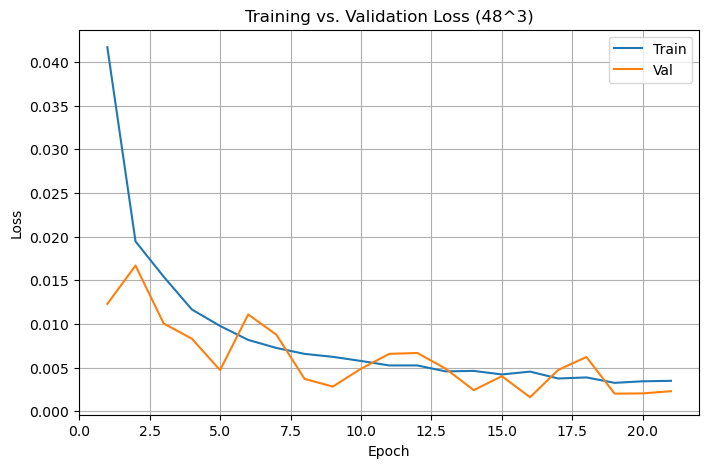

In [10]:

# Plot training and validation losses
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss (48^3)')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_patch.png")
plt.show()


C:\Users\DCervin\AppData\Local\Temp\ipykernel_22392\1186505588.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_autoencoder_patch.p

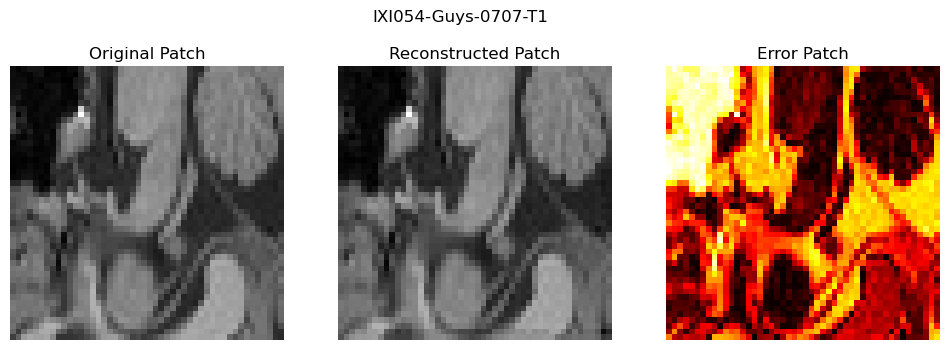

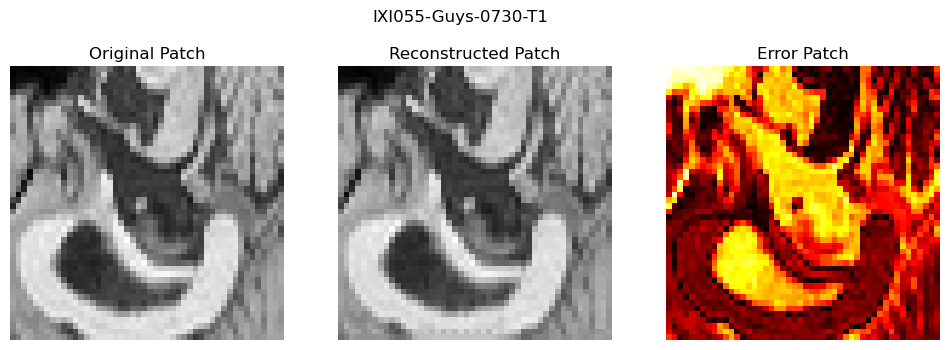

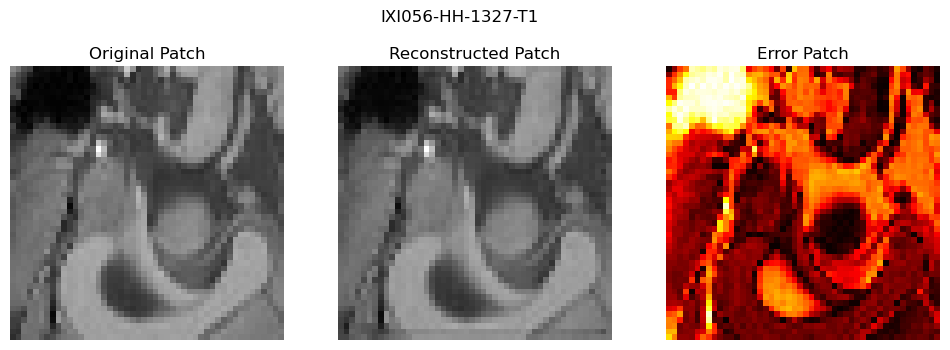

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetAutoencoder3D().to(device)
model.load_state_dict(torch.load("unet_autoencoder_patch.pt", map_location=device))
val_files = sorted(glob(r'D:\DS18\data\IXI-T1_resampled\val\*.nii.gz'))  # or whichever list you held out for validation

# Inference on 48³ patches, saving correct NIfTI metadata
def run_inference_patch(model, nifti_path, target_size=(48,48,48)):
    """
    1) Center-crop or resample to 48×48×48
    2) Z-score + min-max normalize → [0,1]
    3) Run through model
    4) Denormalize output → original scale
    5) Compute absolute error map
    6) Return: patch_array, recon_array, error_array, patch_origin, patch_spacing, patch_direction
    """
    img = sitk.ReadImage(nifti_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)   # shape: [D_orig, H_orig, W_orig]
    D, H, W = arr.shape
    d, h, w = target_size

    orig_origin = np.array(img.GetOrigin())    # (x, y, z)
    orig_sp    = np.array(img.GetSpacing())    # (x-spacing, y-spacing, z-spacing)
    direction  = img.GetDirection()            # tuple length=9

    # --- 1) Center-crop if larger, else resample to 48³ ---
    if (D >= d) and (H >= h) and (W >= w):
        sd = (D - d)//2
        sh = (H - h)//2
        sw = (W - w)//2
        patch = arr[sd:sd+d, sh:sh+h, sw:sw+w]

        # Compute patch-origin in physical space:
        # arr index [z,y,x] corresponds to origin + index*spacing
        patch_origin = (
            orig_origin[0] + sw * orig_sp[0],
            orig_origin[1] + sh * orig_sp[1],
            orig_origin[2] + sd * orig_sp[2]
        )
        patch_spacing = tuple(orig_sp.tolist())
        patch_direction = direction

    else:
        # Resample so that output size = (w,h,d)
        # (SimpleITK uses size=(W,H,D) and spacing=(x,y,z))
        orig_sz = np.array(img.GetSize())  # (W_orig, H_orig, D_orig)
        # Compute new spacing so that new_size * new_spacing = original_size * original_spacing
        new_sp = (
            orig_sp[2] * (orig_sz[2]/d),   # z → depth
            orig_sp[1] * (orig_sz[1]/h),   # y
            orig_sp[0] * (orig_sz[0]/w)    # x
        )
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing((new_sp[2], new_sp[1], new_sp[0]))  # (x,y,z)
        resampler.SetSize((w, h, d))  # (W,H,D)
        resampler.SetOutputOrigin(img.GetOrigin())
        resampler.SetOutputDirection(img.GetDirection())
        resampler.SetInterpolator(sitk.sitkLinear)
        img_res = resampler.Execute(img)

        patch = sitk.GetArrayFromImage(img_res).astype(np.float32)

        patch_origin  = img_res.GetOrigin()
        patch_spacing = img_res.GetSpacing()
        patch_direction = img_res.GetDirection()

    # --- 2) Z-score + min-max normalize patch → [0,1] ---
    mean, std = np.mean(patch), np.std(patch)
    z = (patch - mean) / (std + 1e-5)
    zmin, zmax = z.min(), z.max()
    z = (z - zmin) / (zmax - zmin + 1e-5)
    z = np.clip(z, 0.0, 1.0)

    inp = torch.tensor(z[np.newaxis, np.newaxis, ...], dtype=torch.float32).to(device)
    # shape [1,1,48,48,48]

    # --- 3) Model inference ---
    with torch.no_grad():
        model.eval()
        out = model(inp).cpu().numpy()[0, 0]  # [48,48,48]

    # --- 4) Denormalize reconstruction back to original intensities ---
    recon = out * (std + 1e-5) + mean

    # --- 5) Compute absolute error map in original scale ---
    error = np.abs(patch - recon).astype(np.float32)

    return patch, recon, error, patch_origin, patch_spacing, patch_direction

# Apply to first 3 validation volumes
for path in val_files[:3]:
    base = os.path.basename(path).replace('.nii.gz', '')
    orig_patch, recon_patch, err_patch, origin, spacing, direction = run_inference_patch(model, path)

    # --- Save reconstruction as NIfTI with correct metadata ---
    recon_img = sitk.GetImageFromArray(recon_patch)
    recon_img.SetOrigin(origin)
    recon_img.SetSpacing(spacing)
    recon_img.SetDirection(direction)
    sitk.WriteImage(recon_img, f"{base}_patch_recon.nii.gz")

    # --- Save error-map as NIfTI ---
    error_img = sitk.GetImageFromArray(err_patch)
    error_img.SetOrigin(origin)
    error_img.SetSpacing(spacing)
    error_img.SetDirection(direction)
    sitk.WriteImage(error_img, f"{base}_patch_error.nii.gz")

    # --- Visualize middle slice ---
    idx = orig_patch.shape[0] // 2
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_patch[idx], cmap='gray')
    plt.title('Original Patch')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(recon_patch[idx], cmap='gray')
    plt.title('Reconstructed Patch')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(err_patch[idx], cmap='hot')
    plt.title('Error Patch')
    plt.axis('off')

    plt.suptitle(base)
    plt.savefig(f"{base}_patch_visual.png")
    plt.show()


In [12]:
# Inference on a few validation patches and save outputs
def run_inference_patch(model, nifti_path, target_size=(48,48,48)):
    """
    1) Center-crop or resample to 48×48×48
    2) Z-score + min-max normalize → [0,1]
    3) Run through model
    4) Denormalize output → original scale
    5) Compute absolute error map
    """
    img = sitk.ReadImage(nifti_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # shape: [D_orig, H_orig, W_orig]
    D, H, W = arr.shape
    d, h, w = target_size

    # --- 1) Center-crop if larger, else resample ---
    if (D >= d) and (H >= h) and (W >= w):
        sd = (D - d) // 2
        sh = (H - h) // 2
        sw = (W - w) // 2
        patch = arr[sd:sd+d, sh:sh+h, sw:sw+w]
    else:
        # Compute new spacing so that output size = (w, h, d) in SimpleITK’s (W,H,D) order
        orig_sp = img.GetSpacing()  # (x_spacing, y_spacing, z_spacing)
        orig_sz = img.GetSize()     # (W_orig, H_orig, D_orig)
        new_sp = (
            orig_sp[2] * (orig_sz[2] / d),
            orig_sp[1] * (orig_sz[1] / h),
            orig_sp[0] * (orig_sz[0] / w)
        )
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing((new_sp[2], new_sp[1], new_sp[0]))  # (x,y,z) = (w axis, h axis, d axis)
        resampler.SetSize((w, h, d))
        resampler.SetOutputOrigin(img.GetOrigin())
        resampler.SetOutputDirection(img.GetDirection())
        resampler.SetInterpolator(sitk.sitkLinear)
        img_res = resampler.Execute(img)
        patch = sitk.GetArrayFromImage(img_res).astype(np.float32)

    # --- 2) Z-score → min-max normalize to [0, 1] ---
    mean, std = np.mean(patch), np.std(patch)
    z = (patch - mean) / (std + 1e-5)
    zmin, zmax = z.min(), z.max()
    z = (z - zmin) / (zmax - zmin + 1e-5)
    z = np.clip(z, 0.0, 1.0)

    inp = torch.tensor(z[np.newaxis, np.newaxis, ...], dtype=torch.float32).to(device)  
    # shape: [1, 1, 48, 48, 48]

    # --- 3) Run through model (no grad) ---
    with torch.no_grad():
        model.eval()
        out = model(inp).cpu().numpy()[0, 0]  # shape: [48, 48, 48]

    # --- 4) Denormalize reconstruction back to original intensity scale ---
    recon = out * (std + 1e-5) + mean

    # --- 5) Compute absolute error map in original scale ---
    error = np.abs(patch - recon).astype(np.float32)

    return patch, recon, error

# Demo on first 3 validation volumes
for path in val_files[:3]:
    base = os.path.basename(path).replace('.nii.gz', '')
    orig_patch, recon_patch, err_patch = run_inference_patch(model, path)

    # --- Save reconstructions as NIfTI ---
    ref_img = sitk.ReadImage(path)  # reference to copy origin/direction
    recon_img = sitk.GetImageFromArray(recon_patch)
    recon_img.CopyInformation(ref_img)
    sitk.WriteImage(recon_img, f"{base}_patch_recon.nii.gz")

    error_img = sitk.GetImageFromArray(err_patch)
    error_img.CopyInformation(ref_img)
    sitk.WriteImage(error_img, f"{base}_patch_error.nii.gz")

    # --- Visualize the middle axial slice of each patch ---
    idx = orig_patch.shape[0] // 2
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_patch[idx], cmap='gray')
    plt.title('Original Patch')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(recon_patch[idx], cmap='gray')
    plt.title('Reconstructed Patch')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(err_patch[idx], cmap='hot')
    plt.title('Error Patch')
    plt.axis('off')

    plt.suptitle(base)
    plt.savefig(f"{base}_patch_visual.png")
    plt.show()


RuntimeError: Exception thrown in SimpleITK Image_CopyInformation: D:\bld\libsimpleitk_1745866303479\work\Code\Common\src\sitkImage.cxx:353:
sitk::ERROR: Source image size of [ 128, 256, 256 ] does not match this image's size of [ 48, 48, 48 ]!